In [1]:
import os, sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path
import pandas as pd
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt

chapter = "chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from part31_superposition_and_saes.utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)
device = t.device("cuda" if t.cuda.is_available() else "cpu")

if not t.backends.mps.is_available():
    if not t.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = t.device("mps")

MAIN = __name__ == "__main__"

In [16]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    data_size: int = 100
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0


class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device)
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:

        h = einops.einsum(features, self.W, "... instances features, instances n_hidden features -> ... instances n_hidden")
        
        output = einops.einsum(h, self.W, "... instances n_hidden, instances n_hidden features -> ... instances features")
        
        return F.relu(output + self.b_final).to(device)


    def generate_batch(self, data_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        features = t.rand((data_size, self.cfg.n_instances, self.cfg.n_features), device = self.W.device)
    
        feature_seed = t.rand((data_size, self.cfg.n_instances, self.cfg.n_features), device = self.W.device)
        
        feat_is_present = feature_seed <= self.feature_probability
        
        batch = t.where(feat_is_present, features, 0.0)
        
        return batch


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `model.importance` will always have shape (n_instances, n_features).
        '''
        squared_loss = self.importance * (batch - out) ** 2
    
        loss = einops.reduce(squared_loss, "batch instances features -> instances", "mean")
        
        summed_loss = loss.sum()
        
        return summed_loss, loss


    def optimize(
        self,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))
        
        losses = []
        summed_losses = []
        batch = self.generate_batch(self.cfg.data_size)

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            out = self(batch)
            summed_loss, loss = self.calculate_loss(out, batch)
            losses.append(loss.detach().cpu().clone().numpy().tolist())
            summed_losses.append(summed_loss.detach().cpu().clone().item())
            summed_loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=summed_loss.item()/self.cfg.n_instances, lr=step_lr)
                
        return summed_losses,losses, batch

In [3]:
def feature_probability(n_instances):
    feature_prob = (50 ** -t.linspace(0, 1, n_instances))
    feature_prob = einops.rearrange(feature_prob, "instances -> instances ()")
    return feature_prob

def feature_importance(n_features):
    importance = (0.9 ** t.arange(n_features))
    importance = einops.rearrange(importance, "features -> () features")
    return importance
    

In [10]:
cfg = Config(
    n_instances = 8,
    n_features = 100,
    n_hidden = 2,
    data_size = 15
)

# importance varies within features for each instance
importance = feature_importance(cfg.n_features)

# sparsity is the same for all features in a given instance, but varies over instances
feature_prob = feature_probability(cfg.n_instances)

In [ ]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_prob,
)
summed_losses, losses, batch = model.optimize(steps=10_000)

In [ ]:
loss_df = pd.DataFrame(losses, columns=[str(np.round(prob.item(),3)) for prob in feature_prob])
loss_df["total_loss"] = loss_df.apply(lambda x: x.sum(),axis = 1)

In [ ]:
fig = np.log(loss_df).plot(title = f"Loss Curves: {cfg.n_features} features represented in 2D space", height=600).update_layout(xaxis_title="Steps", yaxis_title="Log loss")
fig.write_image("higher_input_feature_plots/random_test.png")

In [ ]:
np.log(loss_df).shape

In [ ]:
loss_df.columns.name = 'Sparsity'
np.log(loss_df).plot(title = f"Loss Curves: {cfg.n_features} features represented in 2D space", height=600).update_layout(
    xaxis_title="Steps", yaxis_title="Log loss"
).show()

In [ ]:
plot_features_in_2d(
    model.W.detach(),
    colors = model.importance,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_prob.squeeze()],
)

In [65]:
def different_data_size_runs(data_size):
    print(f"data size:{data_size}")

    cfg = Config(
            n_instances = 8,
            n_features = 100,
            n_hidden = 2,
            data_size = 15
        )

    
    # importance varies within features for each instance
    importance = feature_importance(cfg.n_features)
    
    # sparsity is the same for all features in a given instance, but varies over instances
    feature_prob = feature_probability(cfg.n_instances)

    model = Model(
        cfg = cfg,
        device = device,
        importance = importance,
        feature_probability = feature_prob,
    )
    summed_losses, losses, batch = model.optimize(steps=10_000)

    test_batch = model.generate_batch(model.cfg.data_size)
    test_out = model(test_batch)
    test_summed_loss, test_losses = model.calculate_loss(test_out, test_batch)

    results_dict = {}
    results_dict["W"] = model.W.detach()
    results_dict["b"] = model.b_final.detach()
    results_dict["summed_loss"] = summed_losses
    results_dict["losses"] = losses
    results_dict["test_summed_loss"] = test_summed_loss
    results_dict["test_losses"] = test_losses
    results_dict["inputs"] = batch
    
    
    return results_dict

In [66]:
data_sizes = [3, 5, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]

results_list = []

for data_size in data_sizes:
    print(f"data_size: {data_size}")
    results_list.append(different_data_size_runs(data_size))

data_size: 3
data size:3


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 5
data size:5


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 8
data size:8


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 10
data size:10


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 15
data size:15


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 30
data size:30


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 50
data size:50


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 100
data size:100


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 200
data size:200


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 500
data size:500


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 1000
data size:1000


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 2000
data size:2000


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 5000
data size:5000


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 10000
data size:10000


  0%|          | 0/10000 [00:00<?, ?it/s]

data_size: 20000
data size:20000


  0%|          | 0/10000 [00:00<?, ?it/s]

In [61]:
def avg_frob_norm(W):
    return np.mean([t.norm(w).item() for w in W])

def max_frob_norm(W):
    return np.max([t.norm(w).item() for w in W])

def index_frob_norm(W,i):
    return [t.norm(w).item() for w in W][i]

In [64]:
for i in range(len(data_sizes)):

    W = results_list[i]["W"].cpu()
    # print(f"avg norm: {avg_frob_norm(W)}")
    print(f"last norm: {index_frob_norm(W,-1)}")
    # print(f"max norm: {max_frob_norm(W)}")

last norm: 8.097021102905273
last norm: 5.55134391784668
last norm: 6.467559337615967
last norm: 5.5555243492126465
last norm: 6.473383903503418
last norm: 5.925631999969482
last norm: 3.80073618888855
last norm: 9.422000885009766
last norm: 4.9649786949157715
last norm: 7.473561763763428
last norm: 5.935674667358398
last norm: 2.719949960708618
last norm: 6.773313522338867
last norm: 9.600364685058594
last norm: 6.0533623695373535


In [103]:
for i in range(len(data_sizes)):
    print(results_list[i]["test_summed_loss"].cpu().item())

0.34228289127349854
1.4751590490341187
0.42150846123695374
1.1340680122375488
0.8103407621383667
0.3322650194168091
1.1310644149780273
0.3601115942001343
0.3738115727901459
0.42562758922576904
0.7804781198501587
2.2127270698547363
0.3971743583679199
0.32578611373901367
0.41920775175094604


In [110]:
most_sparse_test_loss = []
overall_loss = []
for i in range(len(data_sizes)):
    most_sparse_test_loss.append(results_list[i]["test_losses"].cpu()[-1].item()*100)
    overall_loss.append(results_list[i]["test_summed_loss"].cpu().item())

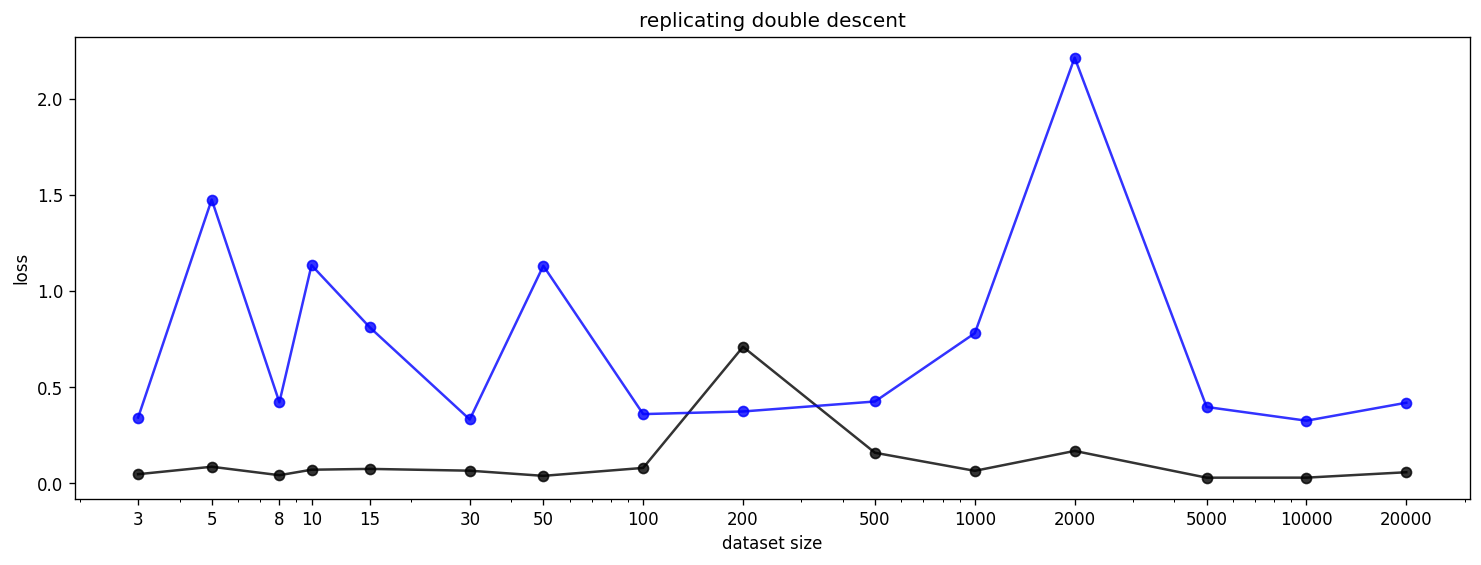

In [119]:
### visualize loss

fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=120)

# ax.axhline(1, linestyle="--", color="grey")
ax.set_ylabel("loss")
ax.set_xlabel("dataset size")
ax.plot(data_sizes, most_sparse_test_loss, '-o', color="black", alpha=0.8)
ax.plot(data_sizes, overall_loss, '-o', color="blue", alpha=0.8)
ax.set_xscale("log")
ax.set_title("replicating double descent")

ax.set_xticks(data_sizes)
ax.set_xticklabels(data_sizes)


plt.show();

In [44]:
results_list[i]["W"].cpu()[-1].shape

torch.Size([2, 100])

In [57]:
hidden_vectors

tensor([[-6.9756e-03, -1.0194e-03],
        [ 0.0000e+00,  0.0000e+00],
        [ 1.6018e+00,  1.1157e+00],
        [ 1.2060e-03,  1.9997e-03],
        [ 5.0817e-01, -1.1779e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 6.1338e-01,  1.3931e+00],
        [ 1.8113e+00,  1.4212e-01],
        [ 0.0000e+00,  0.0000e+00],
        [ 1.6683e+00, -6.1867e-01],
        [-5.5341e-01,  6.6815e-01],
        [ 2.6364e-01,  1.3107e-02],
        [-9.6691e-01, -8.5744e-03],
        [-5.3248e-01, -6.7109e-01],
        [-3.8563e-03, -5.7913e-04]])

In [55]:
hidden_vectors[0].min(), hidden_vectors[0].max()

(tensor(-0.0070), tensor(-0.0010))

/var/folders/9b/k67tngbx13jgzw5kjx9_d0tc0000gn/T/ipykernel_30767/3753948514.py:34: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[1][i].set_xlim(c*hidden_vectors[0].min().item(), c*hidden_vectors[0].max().item())
/var/folders/9b/k67tngbx13jgzw5kjx9_d0tc0000gn/T/ipykernel_30767/3753948514.py:35: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[1][i].set_ylim(c*hidden_vectors[1].min().item(), c*hidden_vectors[1].max().item())


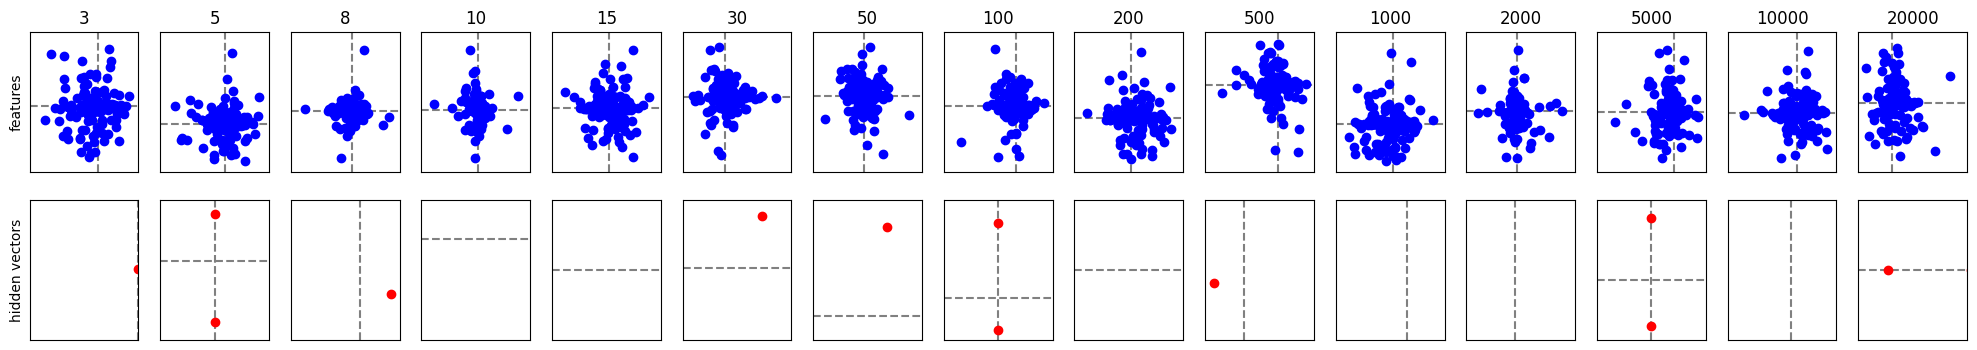

In [59]:
#### visualize features

## think about centering each plot at 0

fig, ax = plt.subplots(2, len(data_sizes), figsize=(25, 4))
c = 1.3

ax[0][0].set_ylabel("features")
ax[1][0].set_ylabel("hidden vectors")

hidden_vectors_list = []

for i in range(len(data_sizes)):

    W = results_list[i]["W"].cpu()
    inputs = results_list[i]["inputs"].cpu()
    s = data_sizes[i]

    hidden_vectors = einops.einsum(inputs, W, "... instances features, instances n_hidden features -> ... instances n_hidden")[:,-1,:]
    hidden_vectors_list.append(hidden_vectors)

    ax[0][i].scatter(W[0], W[1], color="blue", alpha=1)
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[0][i].set_xlim(c*W[0].min().item(), c*W[0].max().item())
    ax[0][i].set_ylim(c*W[1].min().item(), c*W[1].max().item())
    ax[0][i].set_title(str(s))
    ax[0][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[0][i].axhline(0, linestyle="--", color="grey", zorder=-1)

    ax[1][i].scatter(hidden_vectors[0], hidden_vectors[1], color="red", alpha=1)
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    ax[1][i].set_xlim(c*hidden_vectors[0].min().item(), c*hidden_vectors[0].max().item())
    ax[1][i].set_ylim(c*hidden_vectors[1].min().item(), c*hidden_vectors[1].max().item())
    ax[1][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[1][i].axhline(0, linestyle="--", color="grey", zorder=-1)
    
plt.show();

In [12]:
importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

3


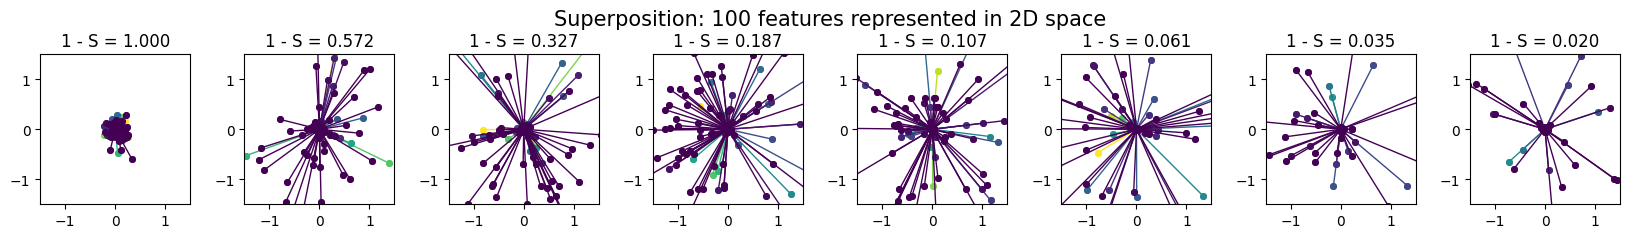

5


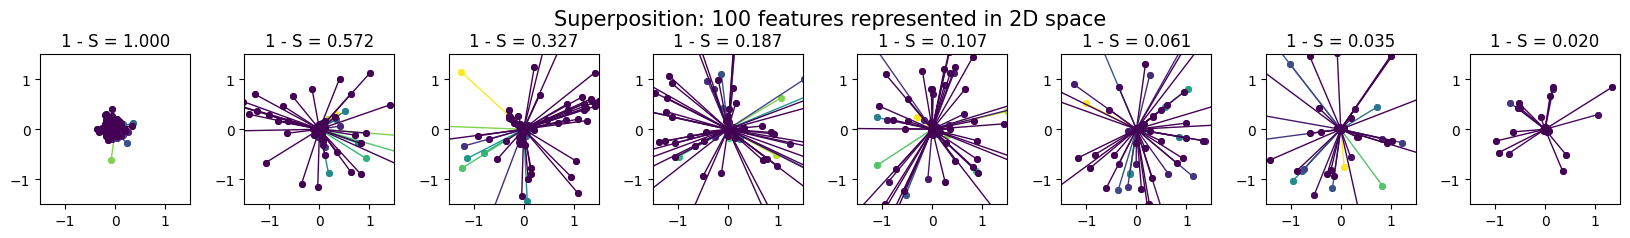

8


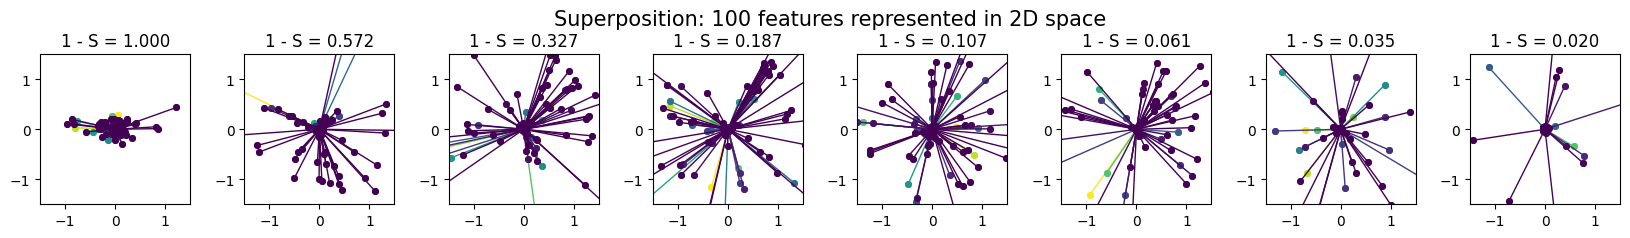

10


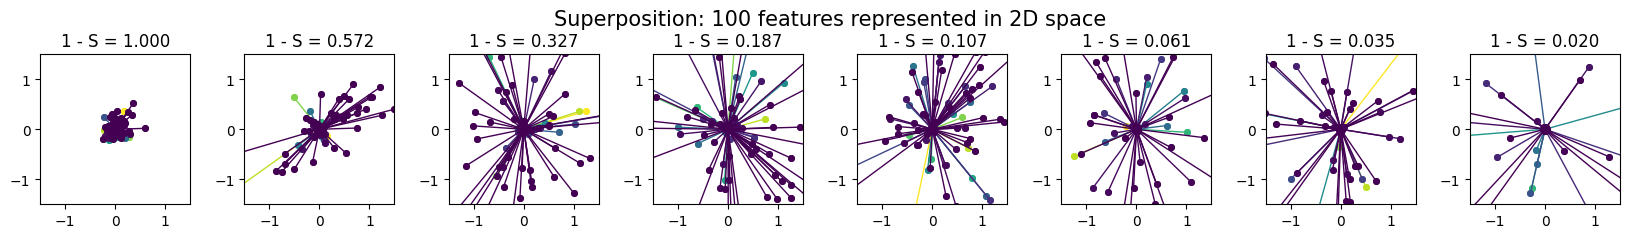

15


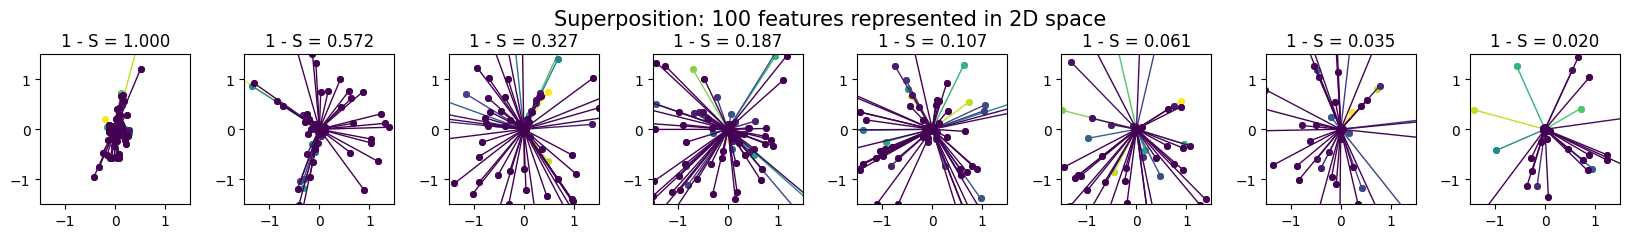

30


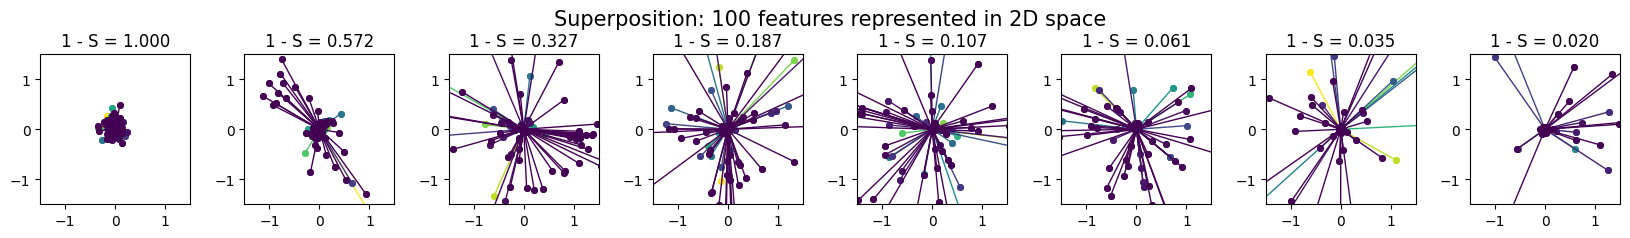

50


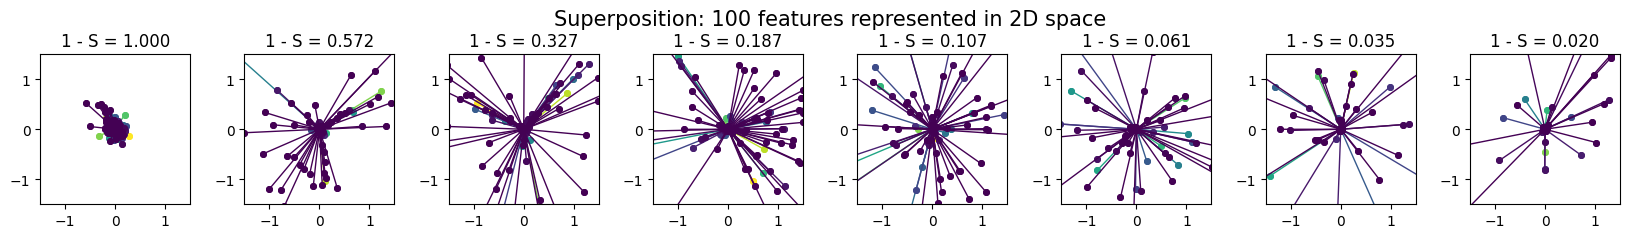

100


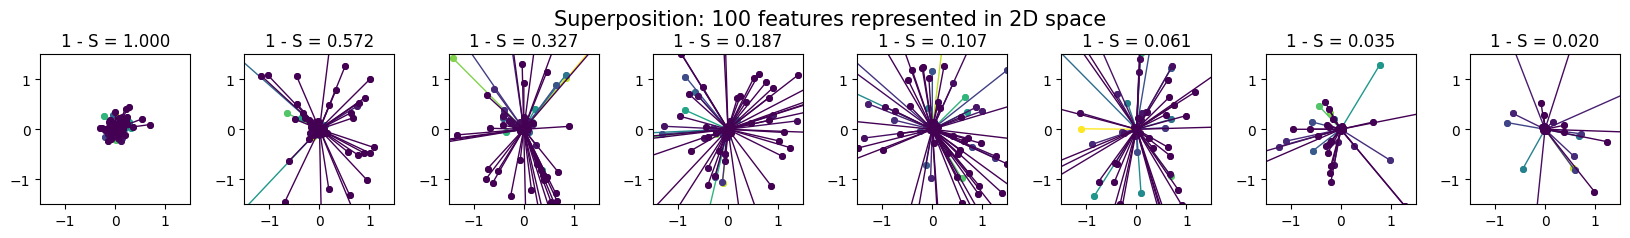

200


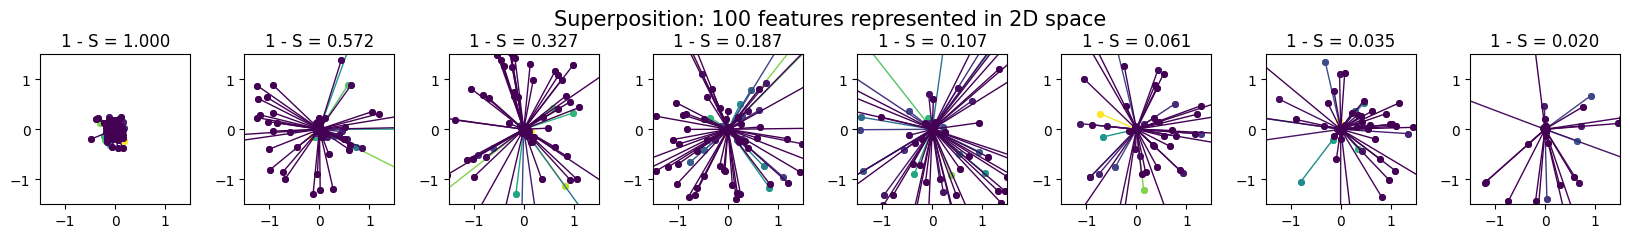

500


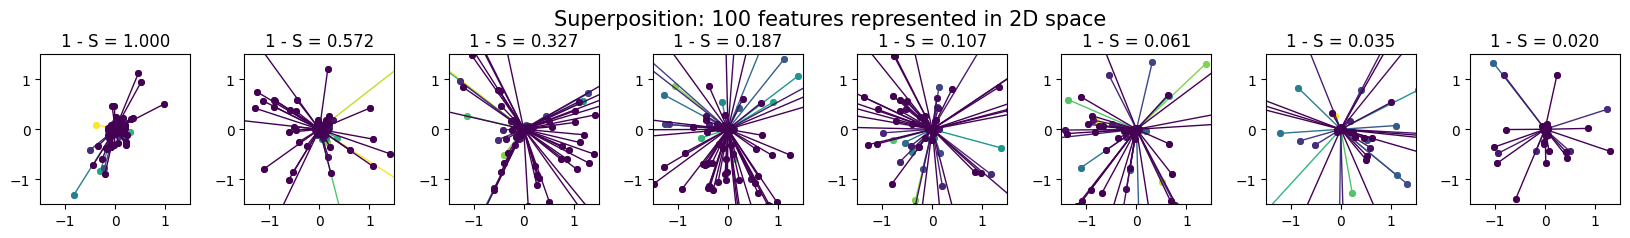

1000


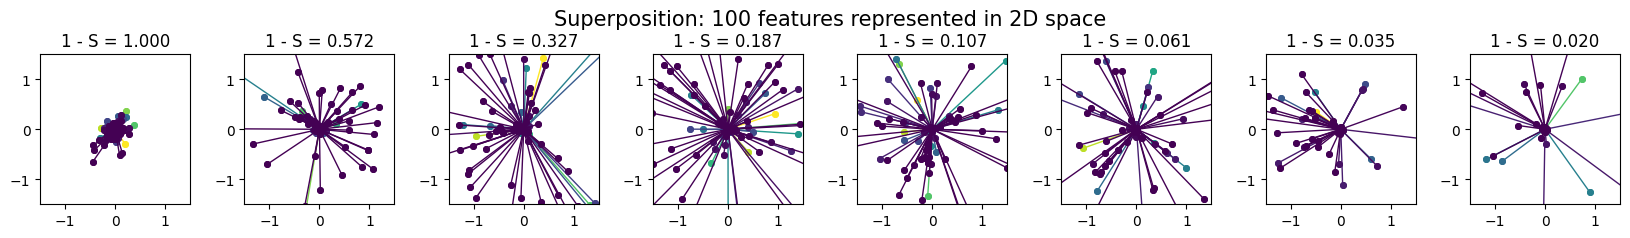

2000


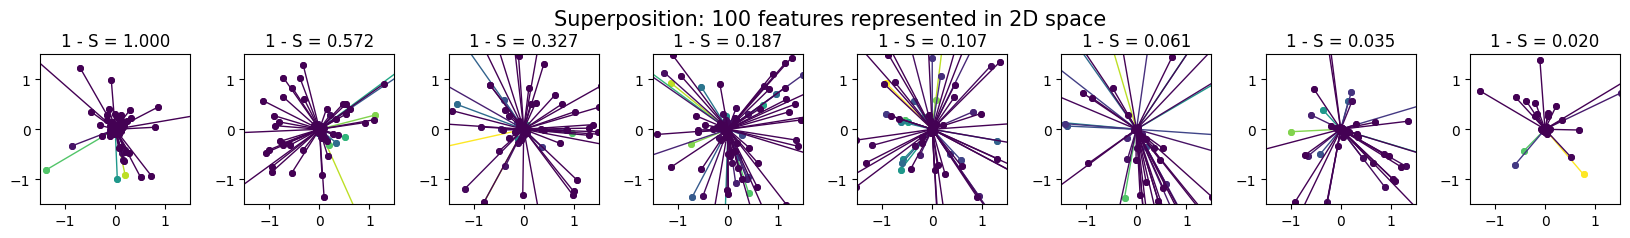

5000


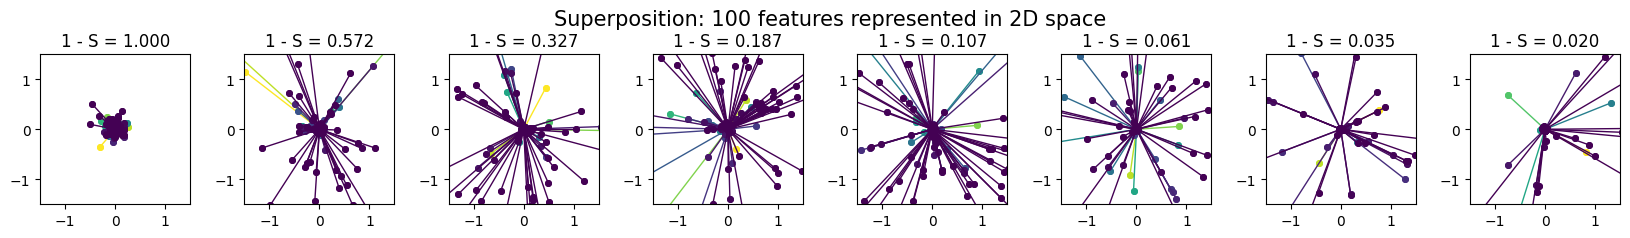

10000


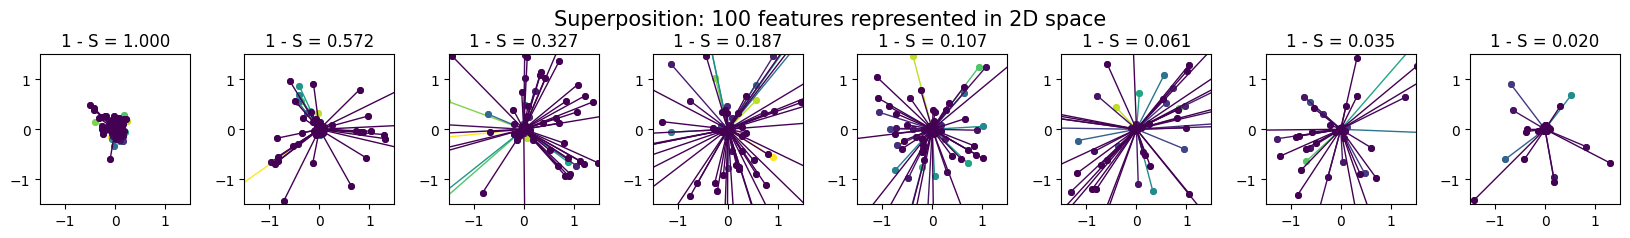

20000


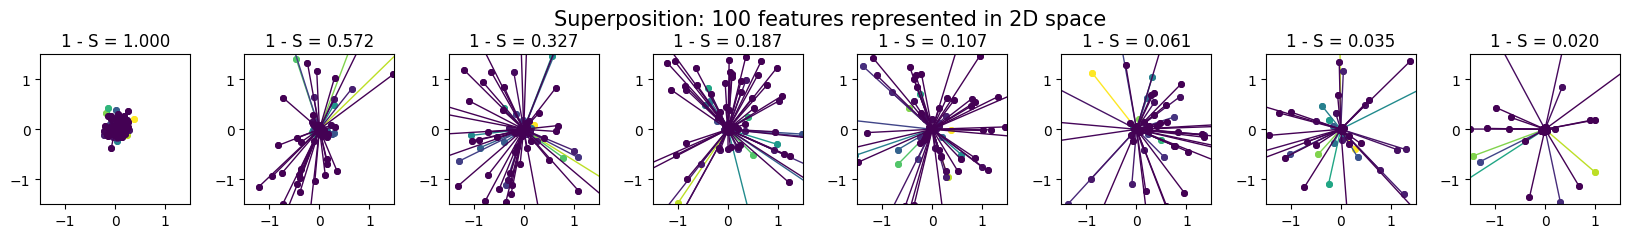

In [14]:
for i in range(len(data_sizes)):
    print(data_sizes[i])

    W = results_list[i]["W"]

    plot_features_in_2d(
        W,
        colors = importance,
        title = f"Superposition: {cfg.n_features} features represented in 2D space",
        subplot_titles = [f"1 - S = {i:.3f}" for i in feature_prob.squeeze()],
    )